In [ ]:
import os,yaml,argparse
import pytorch_lightning as pl
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from datetime import  datetime
from configs.custom_config import dict_to_config,ConfigBase
from tbsim.configs.base import ExperimentConfig
from utils.trainer_utils import prepare_trainer_and_data
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from tbsim.utils.batch_utils import batch_utils
from tbsim.utils.batch_utils import set_global_batch_type
parser = argparse.ArgumentParser(description="Training Script")
parser.add_argument("--config", type=str, default="./config.yaml", help="Path to YAML config")
args = parser.parse_args([])
with open(args.config, "r") as f:
    config_dict = yaml.safe_load(f)
train_config = dict_to_config(ConfigBase, config_dict.get("train", {}))
env_config = dict_to_config(ConfigBase, config_dict.get("env", {}))
algo_config = dict_to_config(ConfigBase, config_dict.get("algo", {}))
default_config = ExperimentConfig(
    train_config=train_config,
    env_config=env_config,
    algo_config=algo_config,
    registered_name=config_dict.get("registered_name", "default_experiment"),
)
  
default_config.lock()
pl.seed_everything(default_config.seed)
set_global_batch_type("trajdata")
set_global_trajdata_batch_env(default_config.train.trajdata_source_train[0])
set_global_trajdata_batch_raster_cfg(default_config.env.rasterizer)
trainer, datamodule,model,_,ckpt_dm = prepare_trainer_and_data(default_config,train_mode="vae",debug=default_config.train.debug)
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
batch = batch_utils().parse_batch(batch)
from tbsim.utils.scene_edit_utils import visualize_guided_rollout
from tbsim.utils.scene_edit_utils import scene_to_video
from tbsim.utils.scene_edit_utils import get_trajdata_renderer

from nuscenes.nuscenes import NuScenes

nusc = NuScenes(
    version='v1.0-trainval',         # 或 'v1.0-trainval' 等
    dataroot='/home/visier/nuscenes',
    verbose=True
)


In [2]:

render_rasterizer = get_trajdata_renderer(
    config_dict['train']['trajdata_source_train'],
    config_dict['train']['trajdata_data_dirs'],
    future_sec=5.2,
    history_sec=3.0,
    raster_size=224,
    px_per_m=2,
    rebuild_maps=False,
    cache_location=config_dict['train']['trajdata_cache_location'],
)
def print_dict_shapes(batch):
    for key, value in batch.items():
        # 检查 value 是否有 shape 属性 (Numpy 数组/Torch Tensor 等)
        if hasattr(value, 'shape'):
            # 将 value.shape 转为 list 以便打印
            print(f"{key}: {list(value.shape)}")
        else:
            # 如果没有 shape 属性，打印类型或者直接打印值
            print(f"{key}: (no shape, type={type(value)})")
print_dict_shapes(batch)

data_idx: [128]
scene_ts: [128]
dt: [128]
agent_name: (no shape, type=<class 'list'>)
agent_type: [128]
curr_agent_state: [128, 7]
agent_hist: [128, 31, 8]
agent_hist_extent: [128, 31, 3]
agent_hist_len: [128]
agent_fut: [128, 52, 8]
agent_fut_extent: [128, 52, 3]
agent_fut_len: [128]
num_neigh: [128]
neigh_indices: [128, 69]
neigh_types: [128, 69]
neigh_hist: [128, 69, 31, 8]
neigh_hist_extents: [128, 69, 31, 3]
neigh_hist_len: [128, 69]
neigh_fut: [128, 69, 52, 8]
neigh_fut_extents: [128, 69, 52, 3]
neigh_fut_len: [128, 69]
robot_fut_len: [128]
map_names: (no shape, type=<class 'list'>)
maps: [128, 3, 224, 224]
maps_resolution: [128]
vector_maps: (no shape, type=<class 'NoneType'>)
rasters_from_world_tf: [128, 3, 3]
agents_from_world_tf: [128, 3, 3]
scene_ids: (no shape, type=<class 'list'>)
history_pad_dir: (no shape, type=<enum 'PadDirection'>)
extras: (no shape, type=<class 'dict'>)
image: [128, 34, 224, 224]
drivable_map: [128, 224, 224]
target_positions: [128, 52, 2]
target_yaws

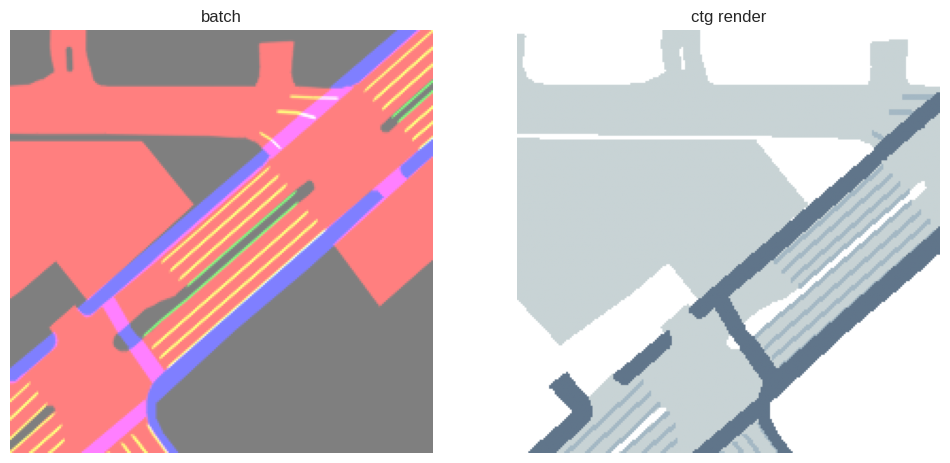

scene-0703


In [39]:
idx = 2
map = batch['maps'][idx]
# image = batch['image'][idx]
%matplotlib inline

import matplotlib.pyplot as plt
scene_name = batch['scene_ids'][idx]
# 第一个图 (RGB map)
map_np = map.permute(1, 2, 0).cpu().numpy()
map_np = map_np*0.5+0.5  # 假设原范围[-1,1]要归一化到[0,1]

# 第二个图 (state_im)
curr_agent_state = batch['curr_agent_state'][idx,0:2]
state_im, raster_from_world = render_rasterizer.render(curr_agent_state, 0, scene_name)

# 创建一个 Figure，两列子图
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# 绘制第一个图
axes[0].imshow(map_np)
axes[0].set_title("batch")
axes[0].axis('off')

# 绘制第二个图
axes[1].imshow(state_im)
axes[1].set_title("ctg render")
axes[1].axis('off')
import numpy as np
my_extent_3d = batch["extent"][idx]  # shape (3,)
extent_2 = my_extent_3d[:2].cpu().numpy()  # shape (2,)

# 加一个 batch 维 / agent 维
extent_2 = extent_2[None, :]  # shape (1,2)

pos_2d = batch["curr_agent_state"][idx][:2].cpu().numpy()  # shape (2,)
pos_2d = pos_2d[None, :]  # shape (1,2)

yaw_val = batch['yaw'][idx].cpu().numpy()  # shape (), a scalar
yaw_val = np.array([yaw_val])  # shape (1,)

# raster_from_agent 同理，如果它本身是 3×3，就不需要扩张batch维
raster_from_agent_np = batch['raster_from_world'][idx].cpu().numpy()  # 看你是否需要
from tbsim.utils.scene_edit_utils import draw_agent_boxes_plt
draw_agent_boxes_plt(
    ax=axes[1],
    pos=pos_2d,         # shape(1,2)
    yaw=yaw_val,        # shape(1,)
    extent=extent_2,    # shape(1,2)
    raster_from_agent=raster_from_agent_np,
)
plt.show()

print(scene_name)

In [ ]:
my_extent_3d = batch["extent"][idx]
extent = my_extent_3d[:2].cpu().numpy() 
raster_from_agent = batch['raster_from_world'][idx].cpu().numpy()
pos = batch['curr_agent_state'][idx][:2].cpu().numpy()
yaw = batch['yaw'][idx].cpu().numpy()
from tbsim.utils.scene_edit_utils import draw_agent_boxes_plt
draw_agent_boxes_plt(
    ax=axes[1],
    pos=pos,
    yaw=yaw,
    extent=extent,
    raster_from_agent=raster_from_agent,

)
print(f"pos:{pos.shape},yaw:{yaw.shape},extent:{extent.shape}")
print(f"pos:{pos},yaw:{yaw},extent:{extent}")

In [36]:
import numpy as np
my_extent_3d = batch["extent"][idx]  # shape (3,)
extent_2 = my_extent_3d[:2].cpu().numpy()  # shape (2,)

# 加一个 batch 维 / agent 维
extent_2 = extent_2[None, :]  # shape (1,2)

pos_2d = batch["curr_agent_state"][idx][:2].cpu().numpy()  # shape (2,)
pos_2d = pos_2d[None, :]  # shape (1,2)

yaw_val = batch['yaw'][idx].cpu().numpy()  # shape (), a scalar
yaw_val = np.array([yaw_val])  # shape (1,)

# raster_from_agent 同理，如果它本身是 3×3，就不需要扩张batch维
raster_from_agent_np = batch['raster_from_world'][idx].cpu().numpy()  # 看你是否需要

draw_agent_boxes_plt(
    ax=axes[1],
    pos=pos_2d,         # shape(1,2)
    yaw=yaw_val,        # shape(1,)
    extent=extent_2,    # shape(1,2)
    raster_from_agent=raster_from_agent_np,
)
plt.show()

In [ ]:
# 1) 根据 scene_name 找到对应 scene_token
scene_token = None
for scene_rec in nusc.scene:
    if scene_rec['name'] == scene_name:
        scene_token = scene_rec['token']
        break
nusc.render_scene(scene_token)

In [ ]:

%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
image_np = image.cpu().numpy() 
def animate_frames(image_np, interval=200):
    """
    使用 Matplotlib FuncAnimation 将 shape=[T,H,W] 的图像序列播放成动画。
    :param image_np: (numpy.ndarray) [T, H, W], 每帧灰度图。
    :param interval: (int) 帧间隔（毫秒），200ms = 5帧/秒。
    :return: animation.FuncAnimation 对象
    """
    fig, ax = plt.subplots()
    
    # 初始化第一帧
    im_plot = ax.imshow(image_np[0], cmap='gray', animated=True)
    ax.set_title("Frame 0")

    def update(frame_idx):
        # 更新图像数据
        im_plot.set_array(image_np[frame_idx])
        # 更新标题
        ax.set_title(f"Frame {frame_idx}")
        return [im_plot]

    ani = animation.FuncAnimation(
        fig, update, 
        frames=range(image_np.shape[0]), 
        interval=interval, 
        blit=True
    )
    return ani
ani = animate_frames(image_np, interval=200)  # interval=200ms => 5fps

# 使用 HTML(ani.to_jshtml()) 在 notebook inline 中嵌入动画
HTML(ani.to_jshtml())